In [2]:
import pandas as pd 
import cv2                 
import numpy as np         
import os,sys                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
from sklearn.model_selection import train_test_split


In [3]:
use_cuda = True


In [4]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [5]:
print(os.listdir("/content/drive/My Drive/cancer/cancer/train"))

['Cancer', 'Normal']


In [6]:

TRAIN_DIR = "/content/drive/My Drive/cancer/cancer/train/"
TEST_DIR =  "/content/drive/My Drive/cancer/cancer/test/"

In [7]:
#Preprocessing 
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['CANCER']:
                label = 1
            else:
                label = 2
    return nextdir, label

In [8]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (150, 150, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [9]:
 #X_train, y_train = preprocessing_data(TRAIN_DIR)

In [10]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['CANCER']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [11]:
X_train, y_train = get_data(TRAIN_DIR)

100%|██████████| 2483/2483 [17:04<00:00,  2.42it/s]


In [12]:
X_test , y_test = get_data(TEST_DIR)

100%|██████████| 620/620 [04:19<00:00,  2.39it/s]


In [13]:
print(X_train.shape,'\n',X_test.shape)

(4961, 150, 150, 3) 
 (1249, 150, 150, 3)


In [14]:
print(y_train.shape,'\n',y_test.shape)

(4961,) 
 (1249,)


In [15]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)



In [16]:
print(y_train.shape,'\n',y_test.shape)

(4961, 3) 
 (1249, 3)


In [17]:

Pimages = os.listdir(TRAIN_DIR + "Cancer")
Nimages = os.listdir(TRAIN_DIR + "Normal")

In [18]:
import matplotlib.pyplot as plt
def plotter(i):
    imagep1 = cv2.imread(TRAIN_DIR+"CANCER/"+Pimages[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(TRAIN_DIR+"NORMAL/"+Nimages[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - No CANCER Vs (Right) - CANCER")
    print("-----------------------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()


In [27]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=1, verbose=1)

In [28]:
filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [29]:
from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [22]:
#X_train=X_train.reshape(5216,3,150,150)
#X_test=X_test.reshape(624,3,150,150)

In [30]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(150,150,3)))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3 , activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(lr=0.00005),
                  metrics=['accuracy'])

print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 150, 150, 64)      18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 64)       

In [31]:
batch_size = 256
epochs = 40

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=epochs)


Epoch 1/40
 13/156 [=>............................] - ETA: 20:05 - loss: 0.0595 - accuracy: 0.9231

In [ ]:
model.save('mymodel.h5')

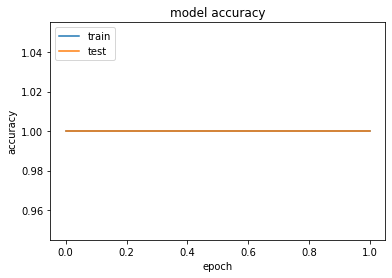

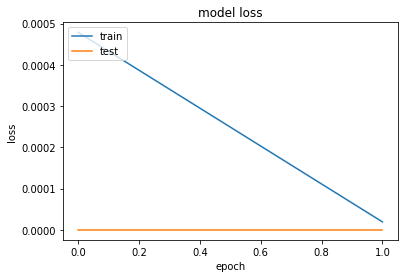

In [ ]:
import matplotlib.pyplot as plt
from keras.models import load_model


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)T

In [ ]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()


In [ ]:
#PRECISION = (TP/(TP+FP))
379/(379+126)

In [ ]:
#RECALL = (TP/(TP+FN))
379 / (379 + 11)


In [ ]:
#ACCURACY = (TP+TN)/(TP+TN+FP+FN)
(379+108)/(379+108+126+11)